In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import dataframe_image as dfi
from pandas.api.types import CategoricalDtype
from matplotlib.ticker import MultipleLocator, FuncFormatter
from scipy.stats import loguniform, uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, brier_score_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV, FrozenEstimator
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
from IPython.display import display
import shap

In [22]:
#Import Accepted_Rejected
Accepted_Rejected_Ord = pd.read_csv('Accepted_Rejected_OrdEncoded.csv')

In [95]:
Accepted_Rejected_Ord['Application'].value_counts()

Application
0    8891402
1    2113597
Name: count, dtype: int64

In [57]:
Accepted_Rejected_Ord.head()

,Loan_Amount,Risk_Score,Debt-Income,State,Employment_Length,Year,Credit_Policy,Application
0,"3,600",677,6,PA,10,2015,1,1
1,"24,700",717,16,SD,10,2015,1,1
2,"20,000",697,11,IL,10,2015,1,1
3,"35,000",787,17,NJ,10,2015,1,1
4,"10,400",697,25,PA,3,2015,1,1


In [7]:
X_Num_Ord = Accepted_Rejected_Ord[['Risk_Score']]
#X_Nominal = Accepted_Rejected_Ord[['State']]
Y = Accepted_Rejected_Ord['Application']

In [8]:
#One Hot Encode Nominal (State).  #Initially tried to incorporate state but am now dropping State completely for efficiency
'''
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_Nominal_One_Hot = encoder.fit_transform(X_Nominal)
X_Nominal_One_Hot_df = pd.DataFrame(
    X_Nominal_One_Hot,
    columns=encoder.get_feature_names_out(X_Nominal.columns),
    index=Accepted_Rejected_Ord.index
)
#Merge
X = pd.merge(
    X_Num_Ord,
    X_Nominal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
'''
X = X_Num_Ord

In [9]:
X.shape

(11004999, 1)

In [10]:
#Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y, random_state=2)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=.2, stratify=Y_train, random_state=2)

#Scale numeric features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#Scale training subsample
scaler_sub = StandardScaler()
X_sub, _, Y_sub, _ = train_test_split(X_train, Y_train, train_size=1000000, stratify=Y_train, random_state=2)
X_sub_scaled = scaler_sub.fit_transform(X_sub)

In [11]:
#Scale Positive Weight
neg = (Y_train == 0).sum()
pos = (Y_train == 1).sum()
spw = neg / pos
print('scale_pos_weight =', spw)

scale_pos_weight = 4.206761812502144


In [62]:
#Logistic Regression (Base)
logreg = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
    solver='saga',
    penalty='l2',
    n_jobs=-1,
    tol=1e-3
)

logreg.fit(X_tr_scaled, Y_tr)

logreg_val_auc = roc_auc_score(Y_val, logreg.predict_proba(X_val_scaled)[:, 1])
logreg_test_auc = roc_auc_score(Y_test, logreg.predict_proba(X_test_scaled)[:, 1])

print('Logistic Regression Validation ROC-AUC:', logreg_val_auc)
print('Logistic Regression Test ROC-AUC:', logreg_test_auc)

C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Validation ROC-AUC: 0.9410254593723
Logistic Regression Test ROC-AUC: 0.9410851834897856


In [63]:
#Logistic Regression (Randomized Search CV)
logreg_param_dist = {'C': loguniform(1e-4, 1e2)}

logreg_randCV = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=logreg_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=2),
    random_state=5,
    n_jobs=-1,
    error_score= np.nan
)

#Fit on scaled subsample
logreg_randCV.fit(X_sub_scaled, Y_sub)
print('Logistic Regression Best Parameters:', logreg_randCV.best_params_)

Logistic Regression Best Parameters: {'C': np.float64(0.00030510379709992175)}


In [64]:
#Refit Logistic Regression Best Parameters on full training data
logreg_best = logreg_randCV.best_estimator_
logreg_best.fit(X_tr_scaled, Y_tr)

#Evaluate
logreg_best_val_auc = roc_auc_score(Y_val, logreg_best.predict_proba(X_val_scaled)[:, 1])
logreg_best_test_auc = roc_auc_score(Y_test, logreg_best.predict_proba(X_test_scaled)[:, 1])

print('Logistic Regression Validation AUC (Best):', logreg_best_val_auc)
print('Logistic Regression Test AUC (Best):', logreg_best_test_auc)

C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Validation AUC (Best): 0.9409995590540899
Logistic Regression Test AUC (Best): 0.9410606784434032


In [65]:
#SGD Classifier (Base)
sgd_lr = SGDClassifier(
    loss='log_loss',
    class_weight='balanced',
    max_iter=10,
    n_jobs=-1,
    tol=1e-3,
    learning_rate='optimal'
)

sgd_lr.fit(X_tr_scaled, Y_tr)

sgd_val_auc = roc_auc_score(Y_val, sgd_lr.predict_proba(X_val_scaled)[:, 1])
sgd_test_auc = roc_auc_score(Y_test, sgd_lr.predict_proba(X_test_scaled)[:, 1])

print('SGD Classifier Validation AUC:', sgd_val_auc)
print('SGD Classifier Test AUC:', sgd_test_auc)

SGD Classifier Validation AUC: 0.9413180594342981
SGD Classifier Test AUC: 0.9413744250925976


In [66]:
#SGD Classifier Regression (Randomized Search CV)
sgd_param_dist = {
    'alpha': uniform(1e-5, 1e-2),
    'max_iter': randint(5, 50),
    'learning_rate': ['optimal', 'invscaling', 'constant'],
    'eta0': uniform(0.001, 0.1),
    'power_t': uniform(0.1, 0.9)
}

sgd_randCV = RandomizedSearchCV(
    estimator=sgd_lr,
    param_distributions=sgd_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

sgd_randCV.fit(X_sub_scaled, Y_sub)
sgd_best = sgd_randCV.best_estimator_
print('SGD Classifier Best Parameters:', sgd_randCV.best_params_)

SGD Classifier Best Parameters: {'alpha': np.float64(0.009841534453572127), 'eta0': np.float64(0.045135491935484676), 'learning_rate': 'invscaling', 'max_iter': 20, 'power_t': np.float64(0.598270456744509)}


In [67]:
#SGD Classifier Regression Best Parameters on full training data
sgd_best.fit(X_tr_scaled, Y_tr)

# Evaluate
sgd_best_val_auc = roc_auc_score(Y_val, sgd_best.predict_proba(X_val_scaled)[:, 1])
sgd_best_test_auc = roc_auc_score(Y_test, sgd_best.predict_proba(X_test_scaled)[:, 1])

print('SGD Classifier Validation AUC (Best):', sgd_best_val_auc)
print('SGD Classifier Test AUC (Best):', sgd_best_test_auc)

SGD Classifier Validation AUC (Best): 0.9414189514464193
SGD Classifier Test AUC (Best): 0.9414744465547681


In [126]:
#Decision Tree (Base)
dt = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    random_state=2,
    class_weight='balanced',
)

dt.fit(X_tr, Y_tr)

dt_val_preds = dt.predict_proba(X_val)[:, 1]
dt_test_preds = dt.predict_proba(X_test)[:, 1]

dt_val_auc = roc_auc_score(Y_val, dt_val_preds)
dt_test_auc = roc_auc_score(Y_test, dt_test_preds)

print('Decision Tree Validation AUC:', dt_val_auc)
print('Decision Tree Test AUC:', dt_test_auc)

Decision Tree Validation AUC: 0.9493584743995404
Decision Tree Test AUC: 0.9492701715403751


In [127]:
#Decision Tree (Randomized Search CV)
dt_param_dist = {
    'max_depth': randint(3, 30),
    'min_samples_split': randint(2, 100),
    'min_samples_leaf': randint(1, 50),
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

dt_randCV = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=2),
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

dt_randCV.fit(X_sub, Y_sub)
print('Decision Tree Best Parameters:', dt_randCV.best_params_)

Decision Tree Best Parameters: {'criterion': 'entropy', 'max_depth': 29, 'max_features': None, 'min_samples_leaf': 38, 'min_samples_split': 41}


In [128]:
#Refit Decision Tree Best Parameters on full training set
dt_best = dt_randCV.best_estimator_
dt_best.fit(X_train, Y_train)

dt_best_val_preds = dt_best.predict_proba(X_val)[:, 1]
dt_best_test_preds = dt_best.predict_proba(X_test)[:, 1]

dt_best_val_auc = roc_auc_score(Y_val, dt_best_val_preds)
dt_best_test_auc = roc_auc_score(Y_test, dt_best_test_preds)

print('Decision Tree Validation AUC (Best):', dt_best_val_auc)
print('Decision Tree Test AUC (Best):', dt_best_test_auc)

Decision Tree Validation AUC (Best): 0.9936858808893835
Decision Tree Test AUC (Best): 0.9922623679379613


In [129]:
#Hist Gradient Boosting (Base)
hgb = HistGradientBoostingClassifier(random_state=2, class_weight='balanced')

hgb.fit(X_tr, Y_tr)

hgb_val_preds = hgb.predict_proba(X_val)[:, 1]
hgb_test_preds = hgb.predict_proba(X_test)[:, 1]

hgb_val_auc = roc_auc_score(Y_val, hgb_val_preds)
hgb_test_auc = roc_auc_score(Y_test, hgb_test_preds)

print('HistGradientBoosting Validation AUC:', hgb_val_auc)
print('HistGradientBoosting Test AUC:', hgb_test_auc)

HistGradientBoosting Validation AUC: 0.9942146138156867
HistGradientBoosting Test AUC: 0.9941852201737634


In [130]:
#Hist Gradient Boosting (Randomized Search CV)
hgb_param_dist = {
    'max_depth': randint(3, 20),
    'min_samples_leaf': randint(10, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_iter': randint(100, 300),
    'max_bins': randint(2, 256)
}
hgb_randCV = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=hgb_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=2),
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

hgb_randCV.fit(X_sub, Y_sub)
print('Best Parameters:', hgb_randCV.best_params_)

Best Parameters: {'learning_rate': np.float64(0.10941475974690253), 'max_bins': 203, 'max_depth': 10, 'max_iter': 277, 'min_samples_leaf': 92}


In [131]:
#Refit Hist Gradient Boosting Best Parameters on full training set
hgb_best = hgb_randCV.best_estimator_
hgb_best.fit(X_train, Y_train)

hgb_best_val_preds = hgb_best.predict_proba(X_val)[:, 1]
hgb_best_test_preds = hgb_best.predict_proba(X_test)[:, 1]

hgb_best_val_auc = roc_auc_score(Y_val, hgb_best_val_preds)
hgb_best_test_auc = roc_auc_score(Y_test, hgb_best_test_preds)

print('HistGradientBoosting Validation AUC (Best):', hgb_best_val_auc)
print('HistGradientBoosting Test AUC (Best):', hgb_best_test_auc)

HistGradientBoosting Validation AUC (Best): 0.9938403052614465
HistGradientBoosting Test AUC (Best): 0.9937794767981257


In [12]:
#LightGBM Base Model (w scale_pos_weight)
lgb = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    random_state=2,
    n_jobs=-1,
    scale_pos_weight=spw,  #Handle imbalance
)

lgb.fit(X_tr, Y_tr)

lgb_val_preds = lgb.predict_proba(X_val)[:, 1]
lgb_test_preds = lgb.predict_proba(X_test)[:, 1]

lgb_val_auc = roc_auc_score(Y_val, lgb_val_preds)
lgb_test_auc = roc_auc_score(Y_test, lgb_test_preds)

print('LightGBM Validation AUC (Base):', lgb_val_auc)
print('LightGBM Test AUC (Base):', lgb_test_auc)

[LightGBM] [Info] Number of positive: 1352702, number of negative: 5690497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 7043199, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192058 -> initscore=-1.436694
[LightGBM] [Info] Start training from score -1.436694
LightGBM Validation AUC (Base): 0.9688222752963827
LightGBM Test AUC (Base): 0.9686485027684385


In [13]:
#Randomized Search CV
lgb_param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.1),
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 10),
    'min_child_samples': randint(50, 300),
    'subsample': uniform(0.6, 0.3),
    'colsample_bytree': uniform(0.6, 0.3),
    'reg_alpha': uniform(0.0, 0.5),
    'reg_lambda': uniform(0.0, 0.5),
}

lgb_randCV = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=lgb_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

lgb_randCV.fit(X_sub, Y_sub)
print('Best Parameters:', lgb_randCV.best_params_)

[LightGBM] [Info] Number of positive: 192058, number of negative: 807942
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192058 -> initscore=-1.436693
[LightGBM] [Info] Start training from score -1.436693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [14]:
#Refit Best Parameters on Full Training Set
lgb_best = lgb_randCV.best_estimator_

# Ensure scale_pos_weight is still applied
lgb_best.set_params(scale_pos_weight=spw)

lgb_best.fit(X_train, Y_train)

lgb_best_val_auc = roc_auc_score(Y_val, lgb_best.predict_proba(X_val)[:, 1])
lgb_best_test_auc = roc_auc_score(Y_test, lgb_best.predict_proba(X_test)[:, 1])

print('LightGBM Validation AUC (Best):', lgb_best_val_auc)
print('LightGBM Test AUC (Best):', lgb_best_test_auc)

[LightGBM] [Info] Number of positive: 1690878, number of negative: 7113121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 8803999, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192058 -> initscore=-1.436693
[LightGBM] [Info] Start training from score -1.436693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [132]:
#XGBoost (Base)
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=spw,
    eval_metric='auc',
    n_jobs=-1,
    random_state=2
)

xgb.fit(X_tr, Y_tr)

xgb_val_preds = xgb.predict_proba(X_val)[:, 1]
xgb_test_preds = xgb.predict_proba(X_test)[:, 1]

xgb_val_auc = roc_auc_score(Y_val, xgb_val_preds)
xgb_test_auc = roc_auc_score(Y_test, xgb_test_preds)

print('XGBoost Base Validation AUC:', xgb_val_auc)
print('XGBoost Base Test AUC:', xgb_test_auc)

XGBoost Base Validation AUC: 0.9951424296270207
XGBoost Base Test AUC: 0.9951123239275426


In [133]:
#XGBoost (Randomized Search CV)
xgb_param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 20)
}

xgb_randCV = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

xgb_randCV.fit(X_sub, Y_sub)
print('Best Parameters:', xgb_randCV.best_params_)

Best Parameters: {'colsample_bytree': np.float64(0.754755954128305), 'learning_rate': np.float64(0.1764033799269002), 'max_depth': 7, 'min_child_weight': 18, 'n_estimators': 150, 'subsample': np.float64(0.9189619756130374)}


In [134]:
#Refit XGBoost Best Parameters on full training set
xgb_best = xgb_randCV.best_estimator_

xgb_best.fit(X_train, Y_train)

xgb_best_val_auc = roc_auc_score(Y_val, xgb_best.predict_proba(X_val)[:, 1])
xgb_best_test_auc = roc_auc_score(Y_test, xgb_best.predict_proba(X_test)[:, 1])

print('XGBoost Validation AUC (Best):', xgb_best_val_auc)
print('XGBoost Test AUC (Best):', xgb_best_test_auc)

XGBoost Validation AUC (Best): 0.9951937552763581
XGBoost Test AUC (Best): 0.9951179914130842


In [135]:
#CatBoost (Base)
cat = CatBoostClassifier(eval_metric='AUC', class_weights=[1, spw], random_seed=2, thread_count=-1, verbose=0)

cat.fit(X_tr, Y_tr, eval_set=(X_val, Y_val))

cat_val_preds = cat.predict_proba(X_val)[:, 1]
cat_test_preds = cat.predict_proba(X_test)[:, 1]

cat_val_auc = roc_auc_score(Y_val, cat_val_preds)
cat_test_auc = roc_auc_score(Y_test, cat_test_preds)

print('CatBoost Base Validation AUC:', cat_val_auc)
print('CatBoost Base Test AUC:', cat_test_auc)

CatBoost Base Validation AUC: 0.9963480795339026
CatBoost Base Test AUC: 0.9963047088204706


In [ ]:
#CatBoost (Randomized Search CV)
#Crashed
'''
cat_param_dist = {
    'iterations': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'depth': randint(3, 12),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
    'border_count': randint(25, 255)
}

cat_randCV = RandomizedSearchCV(
    estimator=cat,
    param_distributions=cat_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=2,
    error_score=np.nan
)

cat_randCV.fit(X_sub, Y_sub)
print('CatBoost Best Parameters:', cat_randCV.best_params_)
'''

In [ ]:
#Refit CatBoost Best Parameters on full training set
'''
cat_best = cat_randCV.best_estimator_
cat_best.fit(X_train, Y_train, eval_set=(X_val, Y_val))

cat_best_val_auc = roc_auc_score(Y_val, cat_best.predict_proba(X_val)[:, 1])
cat_best_test_auc = roc_auc_score(Y_test, cat_best.predict_proba(X_test)[:, 1])

print('CatBoost Validation AUC (Best):', cat_best_val_auc)
print('CatBoost Test AUC (Best):', cat_best_test_auc)
'''

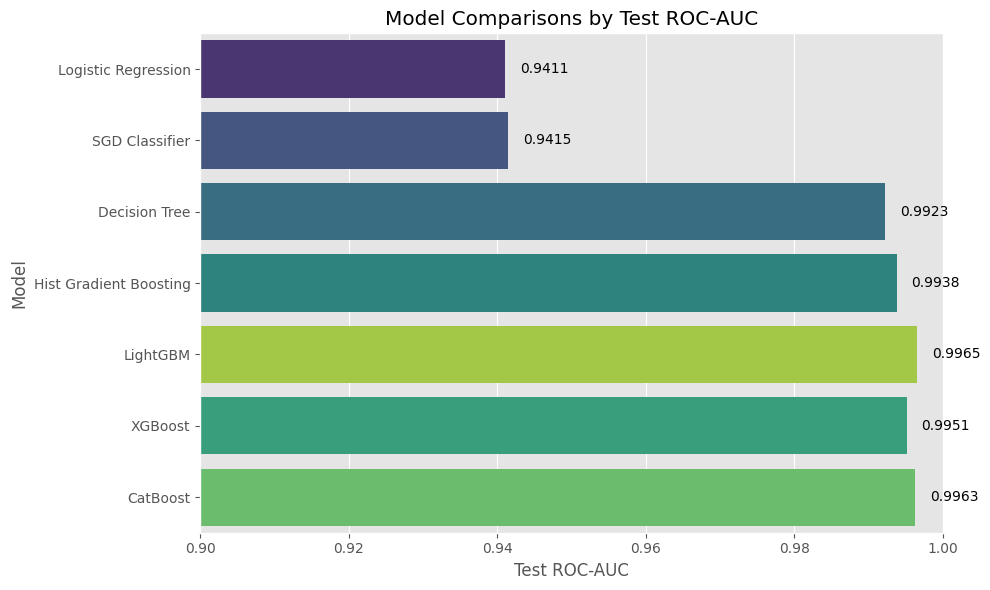

In [136]:
#Bar Plot Comparison of All Scores
model_best_scores = pd.DataFrame({
    'Model': ['Logistic Regression', 'SGD Classifier', 'Decision Tree', 'Hist Gradient Boosting', 'LightGBM', 'XGBoost', 'CatBoost'],
    'Test_AUC': [logreg_best_test_auc, sgd_best_test_auc, dt_best_test_auc, hgb_best_test_auc, lgb_best_test_auc, xgb_best_test_auc, cat_test_auc]})

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Test_AUC',
    y='Model',
    data=model_best_scores,
    hue=model_best_scores['Test_AUC'],
    palette=sns.color_palette('viridis', n_colors=len(model_best_scores)),
    legend=False
)
plt.xlabel('Test ROC-AUC')
plt.title('Model Comparisons by Test ROC-AUC')
plt.xlim(0.9, 1.0)
for index, row in model_best_scores.iterrows():
    plt.text(row.Test_AUC + 0.002, index, f'{row.Test_AUC:.4f}', va='center')
plt.tight_layout()
plt.show()

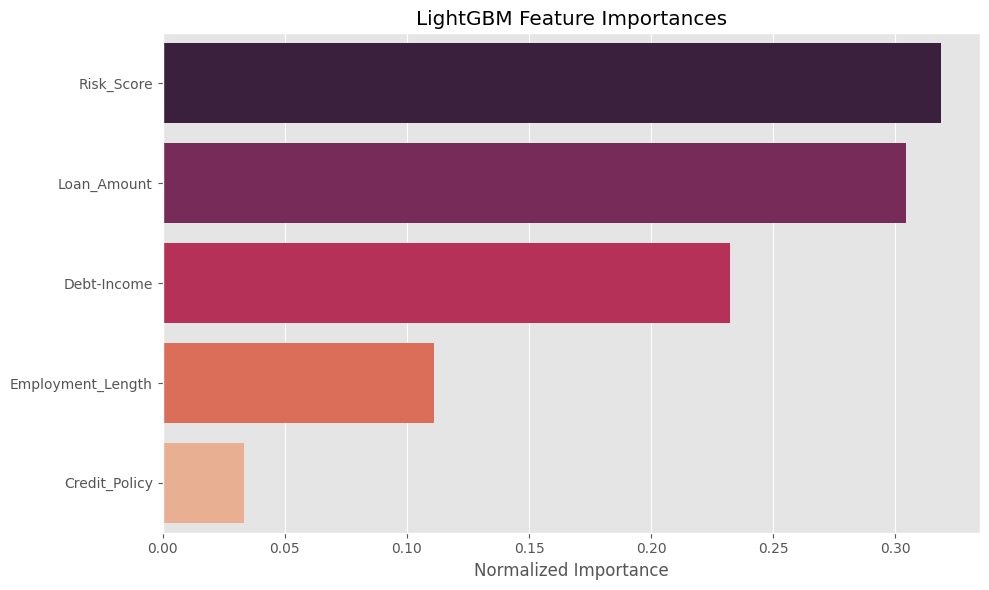

In [103]:
#Normalized Feature Importances for Top Model (LightGBM)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_best.feature_importances_
})

#Normalize (total sums to 1)
feature_importances['Importance'] = feature_importances['Importance'] / feature_importances['Importance'].sum()

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importances,
    hue=feature_importances['Importance'],
    palette=sns.color_palette('rocket', n_colors=len(feature_importances))[::-1],
    dodge=False,
    legend=False
)
plt.title('LightGBM Feature Importances')
plt.xlabel('Normalized Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()

C:\Users\edjwe\pyenv\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


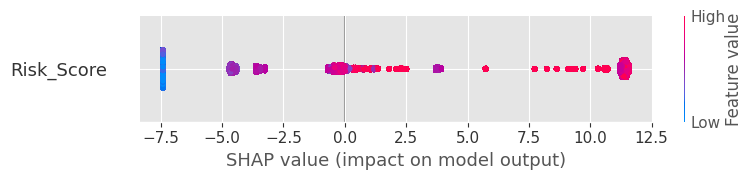

In [15]:
#Beeswarm Plot for Top Model (Light GBM)
explainer = shap.TreeExplainer(lgb_best)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=True)

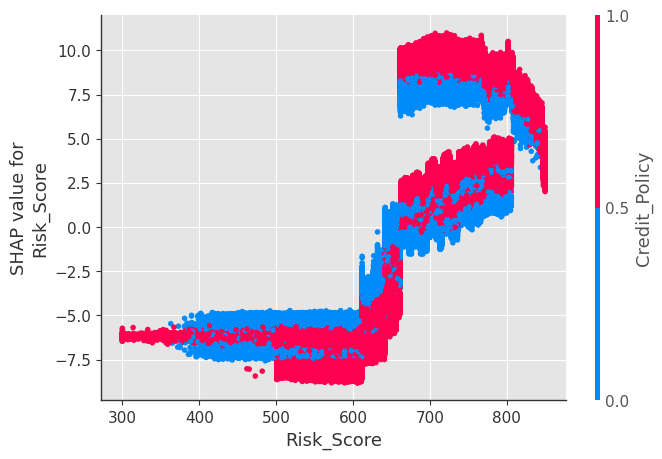

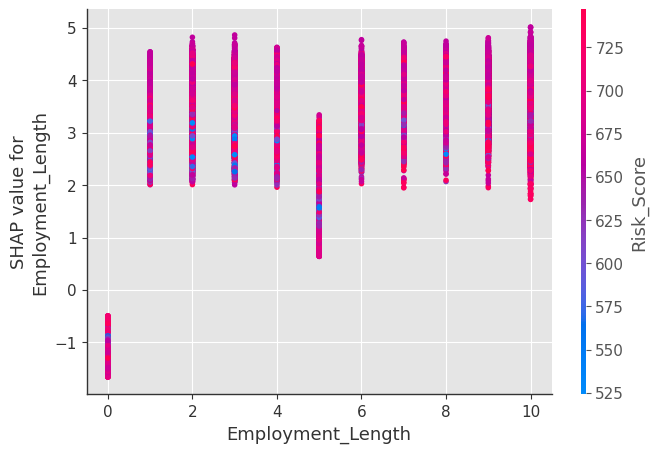

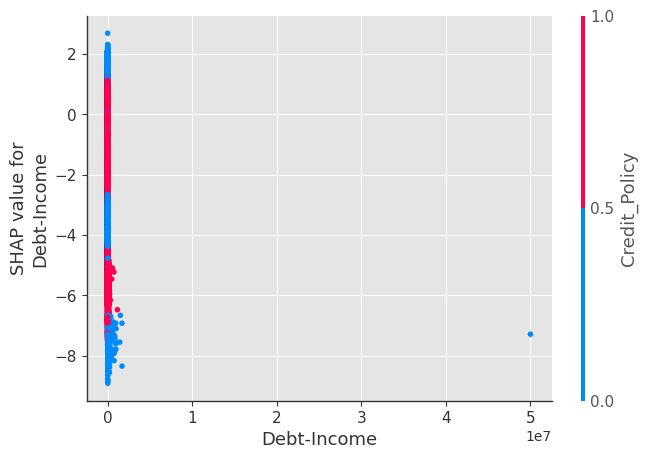

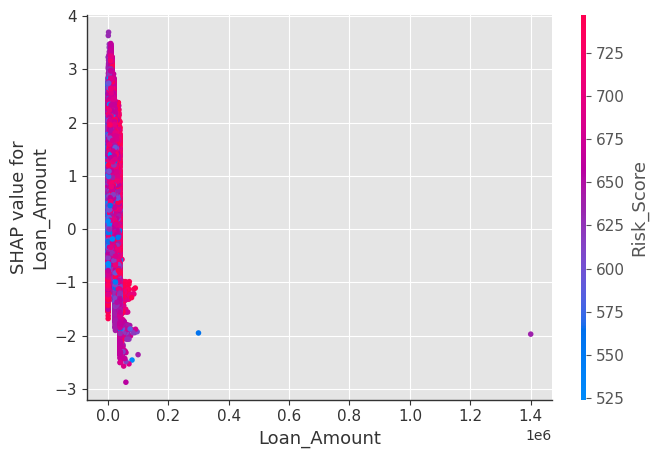

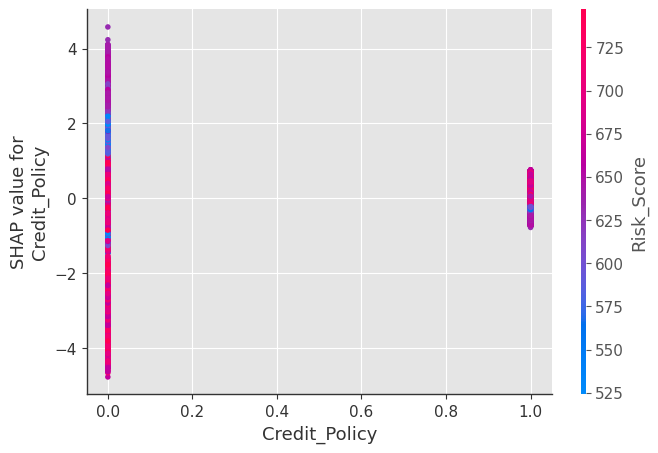

In [153]:
#SHAP Dependence Plots for each feature
shap.dependence_plot('Risk_Score', shap_values, X_test)                 #interaction_index='Loan_Amount'
shap.dependence_plot('Employment_Length', shap_values, X_test)
shap.dependence_plot('Debt-Income', shap_values, X_test)
shap.dependence_plot('Loan_Amount', shap_values, X_test)
shap.dependence_plot('Credit_Policy', shap_values, X_test)

Model classes order: [np.int64(0), np.int64(1)]
Predicted label counts (after using prob for class 1):
 0    1651907
1     549093
Name: count, dtype: int64

Actual label counts (Y_test):
 Application
0    1778281
1     422719
Name: count, dtype: int64


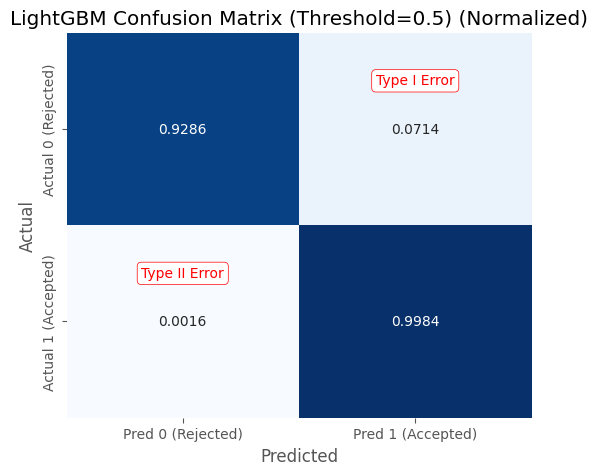

TN= 1,651,249  FP= 127,032 
FN= 658      TP= 422,061
Accuracy:    0.9420
Precision:   0.7687
Recall:      0.9984
Specificity: 0.9286
F1 Score:    0.8686
Kappa:       0.8322
Type I Error (FP Rate):  0.0714
Type II Error (FN Rate): 0.0016


In [16]:
#---Confusion Matrix & Metrics
#Check prediction distribution
pd.Series(lgb_best.predict(X_test)).value_counts(normalize=True)

probs_all = lgb_best.predict_proba(X_test)
classes_order = list(lgb_best.classes_)
print('Model classes order:', classes_order)

#index and prob of positive class
try:
    idx_pos = classes_order.index(1)
except ValueError:
    raise ValueError('Class 1 not found in model.classes_. Y_train/Y_test labels')

lgb_test_probs_for_1 = probs_all[:, idx_pos]

#threshold, predictions
threshold = 0.5
lgb_test_preds = (lgb_test_probs_for_1 >= threshold).astype(int)

#sanity counts
print('Predicted label counts (after using prob for class 1):\n', pd.Series(lgb_test_preds).value_counts())
print('\nActual label counts (Y_test):\n', pd.Series(Y_test).value_counts())

#Confusion Matrix
cm = confusion_matrix(Y_test, lgb_test_preds, labels=[0, 1])
TN, FP, FN, TP = cm.ravel()
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

type1_error = FP / (FP + TN) if (FP + TN) > 0 else np.nan
type2_error = FN / (FN + TP) if (FN + TP) > 0 else np.nan

cm_df = pd.DataFrame(cm_norm,
                     index=['Actual 0 (Rejected)', 'Actual 1 (Accepted)'],
                     columns=['Pred 0 (Rejected)', 'Pred 1 (Accepted)'])
annot_labels = np.array([
    [f'{cm_norm[0,0]:.4f}\n(TN={TN:,})', f'{cm_norm[0,1]:.4f}\n(FP={FP:,})'],
    [f'{cm_norm[1,0]:.4f}\n(FN={FN:,})', f'{cm_norm[1,1]:.4f}\n(TP={TP:,})']
])

plt.figure(figsize=(6,5))
ax = sns.heatmap(
    cm_df,
    annot=annot_labels,
    fmt='',
    cmap='Blues',
    cbar=False
)

#Type I Error Label
ax.text(
    1 + .5, 0 + .3,
    'Type I Error',
    ha='center', va='bottom',
    color='red',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
)

#Type II Error Label
ax.text(
    0 + 0.5, 1 + 0.3,
    'Type II Error',
    ha='center', va='bottom',
    color='red',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
)

plt.title(f'LightGBM Confusion Matrix (Threshold={threshold}) (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Metrics
accuracy    = accuracy_score(Y_test, lgb_test_preds)
precision   = precision_score(Y_test, lgb_test_preds, pos_label=1)
recall      = recall_score(Y_test, lgb_test_preds, pos_label=1)
specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
f1          = f1_score(Y_test, lgb_test_preds, pos_label=1)
kappa       = cohen_kappa_score(Y_test, lgb_test_preds)

print(f'TN= {TN:,}  FP= {FP:,} \nFN= {FN:,}      TP= {TP:,}')
print(f'Accuracy:    {accuracy:.4f}')
print(f'Precision:   {precision:.4f}')
print(f'Recall:      {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score:    {f1:.4f}')
print(f'Kappa:       {kappa:.4f}')
print(f'Type I Error (FP Rate):  {type1_error:.4f}')
print(f'Type II Error (FN Rate): {type2_error:.4f}')

C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Predicted label counts (calibrated, normalized):
 0   1
1   0
Name: proportion, dtype: float64
Actual label counts (Y_test):
 Application
0   1
1   0
Name: proportion, dtype: float64


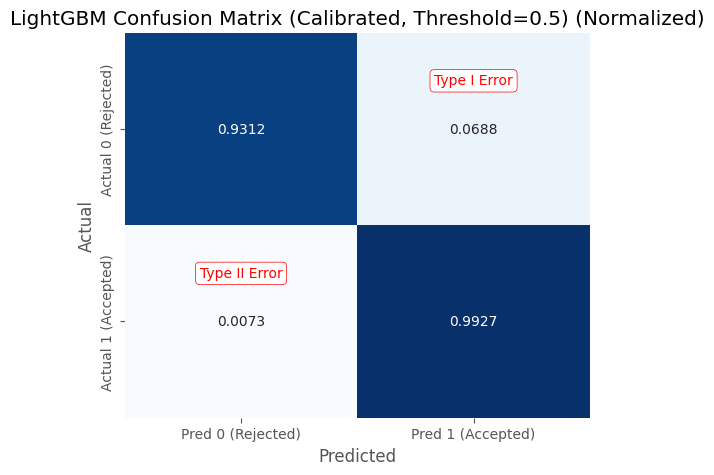

TN= 1,656,021  FP= 122,260 
FN= 3,068     TP= 419,651
Accuracy:    0.9431
Precision:   0.7744
Recall:      0.9927
Specificity: 0.9312
F1 Score:    0.8701
Kappa:       0.8343
Type I Error (FP Rate):  0.0688
Type II Error (FN Rate): 0.0073


In [17]:
#---Calibrated Probability Model & Confusion Matrix

#calibrate LightGBM on validation set
lgb_calibrated = CalibratedClassifierCV(estimator=FrozenEstimator(lgb_best), method='sigmoid', cv=None)
lgb_calibrated.fit(X_val, Y_val)

#calibrated probabilities and predictions
lgb_test_probs_calibrated = lgb_calibrated.predict_proba(X_test)[:, 1]
threshold = 0.5
lgb_test_preds_calibrated = (lgb_test_probs_calibrated >= threshold).astype(int)

#sanity proportions
print('Predicted label proportions (calibrated, normalized):\n',
      pd.Series(lgb_test_preds_calibrated).value_counts(normalize=True))
print('\nActual label proportions (Y_test):\n',
      pd.Series(Y_test).value_counts(normalize=True))


#Confusion Matrix
cm = confusion_matrix(Y_test, lgb_test_preds_calibrated, labels=[0, 1])
TN, FP, FN, TP = cm.ravel()
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

type1_error = FP / (FP + TN) if (FP + TN) > 0 else np.nan
type2_error = FN / (FN + TP) if (FN + TP) > 0 else np.nan

cm_df = pd.DataFrame(cm_norm,
                     index=['Actual 0 (Rejected)', 'Actual 1 (Accepted)'],
                     columns=['Pred 0 (Rejected)', 'Pred 1 (Accepted)'])

annot_labels = np.array([
    [f'{cm_norm[0,0]:.4f}\n(TN={TN:,})', f'{cm_norm[0,1]:.4f}\n(FP={FP:,})'],
    [f'{cm_norm[1,0]:.4f}\n(FN={FN:,})', f'{cm_norm[1,1]:.4f}\n(TP={TP:,})']
])

plt.figure(figsize=(6,5))
ax = sns.heatmap(
    cm_df,
    annot=annot_labels,
    fmt='',
    cmap='Blues',
    cbar=False
)

#Type I Error Label
ax.text(
    1 + .5, 0 + .3,
    'Type I Error',
    ha='center', va='bottom',
    color='red',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
)

#Type II Error Label
ax.text(
    0 + 0.5, 1 + 0.3,
    'Type II Error',
    ha='center', va='bottom',
    color='red',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
)

plt.title(f'LightGBM Confusion Matrix (Threshold={threshold}) (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Metrics
accuracy    = accuracy_score(Y_test, lgb_test_preds_calibrated)
precision   = precision_score(Y_test, lgb_test_preds_calibrated, pos_label=1)
recall      = recall_score(Y_test, lgb_test_preds_calibrated, pos_label=1)
specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
f1          = f1_score(Y_test, lgb_test_preds_calibrated, pos_label=1)
kappa       = cohen_kappa_score(Y_test, lgb_test_preds_calibrated)

print(f'TN= {TN:,}  FP= {FP:,} \nFN= {FN:,}     TP= {TP:,}')
print(f'Accuracy:    {accuracy:.4f}')
print(f'Precision:   {precision:.4f}')
print(f'Recall:      {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score:    {f1:.4f}')
print(f'Kappa:       {kappa:.4f}')
print(f'Type I Error (FP Rate):  {type1_error:.4f}')
print(f'Type II Error (FN Rate): {type2_error:.4f}')

#Confusion Matrix
cm = confusion_matrix(Y_test, lgb_test_preds_calibrated, labels=[0, 1])
TN, FP, FN, TP = cm.ravel()
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

type1_error = FP / (FP + TN) if (FP + TN) > 0 else np.nan
type2_error = FN / (FN + TP) if (FN + TP) > 0 else np.nan

cm_df = pd.DataFrame(cm_norm,
                     index=['Actual 0 (Rejected)', 'Actual 1 (Accepted)'],
                     columns=['Pred 0 (Rejected)', 'Pred 1 (Accepted)'])

annot_labels = np.array([
    [f'{cm_norm[0,0]:.4f}\n(TN={TN:,})', f'{cm_norm[0,1]:.4f}\n(FP={FP:,})'],
    [f'{cm_norm[1,0]:.4f}\n(FN={FN:,})', f'{cm_norm[1,1]:.4f}\n(TP={TP:,})']
])

plt.figure(figsize=(6,5))
ax = sns.heatmap(
    cm_df,
    annot=annot_labels,
    fmt='',
    cmap='Blues',
    cbar=False
)

#Type I Error Label
ax.text(
    1 + .5, 0 + .3,
    "Type I Error (FP)",
    ha='center', va='bottom',
    color="red",
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
)

#Type II Error Label
ax.text(
    0 + 0.5, 1 + 0.3,
    'Type II Error (FN)',
    ha='center', va='bottom',
    color='red',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
)

plt.title(f'LightGBM Confusion Matrix (Threshold={threshold}) (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Metrics
accuracy    = accuracy_score(Y_test, lgb_test_preds_calibrated)
precision   = precision_score(Y_test, lgb_test_preds_calibrated, pos_label=1)
recall      = recall_score(Y_test, lgb_test_preds_calibrated, pos_label=1)
specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
f1          = f1_score(Y_test, lgb_test_preds_calibrated, pos_label=1)
kappa       = cohen_kappa_score(Y_test, lgb_test_preds_calibrated)

print(f'TN= {TN:,}  FP= {FP:,} \nFN= {FN:,}     TP= {TP:,}')
print(f'Accuracy:    {accuracy:.4f}')
print(f'Precision:   {precision:.4f}')
print(f'Recall:      {recall:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1 Score:    {f1:.4f}')
print(f'Kappa:       {kappa:.4f}')
print(f'Type I Error (FP Rate):  {type1_error:.4f}')
print(f'Type II Error (FN Rate): {type2_error:.4f}')

In [110]:
#---Compute All Metrics, Best Model by Accuracy

models = {
    'Logistic' : logreg_best,
    'SGD'      : sgd_best,
    'DecisionTree' : dt_best,
    'HistGB'   : hgb_best,
    'LightGBM' : lgb_best,
    'XGBoost'  : xgb_best,
    'CatBoost' : cat
}

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

rows = []
for name, mdl in models.items():
    if name in ['Logistic', 'SGD']:
        X_input = X_test_scaled  # scaled
    else:
        X_input = X_test         # raw

    # predicted probabilities
    try:
        probs = mdl.predict_proba(X_input)[:,1]
    except Exception:
        probs = None

    y_pred = (probs >= 0.5).astype(int) if probs is not None else mdl.predict(X_input)
    
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()

    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
    acc = accuracy_score(Y_test, y_pred)
    bal_acc = balanced_accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred, zero_division=0)
    rec = recall_score(Y_test, y_pred, zero_division=0)
    spec = specificity_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred, zero_division=0)
    kappa = cohen_kappa_score(Y_test, y_pred)
    roc = roc_auc_score(Y_test, probs) if probs is not None else np.nan
    prec_val, rec_val, _ = precision_recall_curve(Y_test, probs) if probs is not None else (np.nan, np.nan, np.nan)
    pr_auc = auc(rec_val, prec_val) if probs is not None else np.nan
    brier = brier_score_loss(Y_test, probs) if probs is not None else np.nan

    rows.append({
        'Model': name,
        'Accuracy': acc,
        'Balanced Accuracy': bal_acc,
        'Precision': prec,
        'Recall': rec,
        'Specificity': spec,
        'F1': f1,
        'Kappa': kappa,
        'ROC_AUC': roc,
        'PR_AUC': pr_auc,
        'Brier': brier,
        'TP': f'{tp:,}',
        'TN': f'{tn:,}',
        'FP': f'{fp:,}',
        'FN': f'{fn:,}'
        
    })

df = pd.DataFrame(rows).set_index('Model').sort_values('Accuracy', ascending=False)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print('--- Metrics sorted by Accuracy (threshold 0.5) ---')
display(df)

#Summary- best by accuracy & balanced accuracy
best_by_acc = df['Accuracy'].idxmax()
best_by_balacc = df['Balanced Accuracy'].idxmax()
print(f"Best model by ACC (0.5):     {best_by_acc} (accuracy={df.loc[best_by_acc,'Accuracy']:.4f})")
print(f"Best model by BAL_ACC (0.5): {best_by_balacc} (balanced accuracy={df.loc[best_by_balacc,'Balanced Accuracy']:.4f})")

--- Metrics sorted by Accuracy (threshold 0.5) ---


,Accuracy,Balanced Accuracy,Precision,Recall,Specificity,F1,Kappa,ROC_AUC,PR_AUC,Brier,TP,TN,FP,FN
Model,,,,,,,,,,,,,,
CatBoost,0.9784,0.9662,0.9413,0.9465,0.9860,0.9439,0.9305,0.9964,0.9820,0.0163,"400,118","1,753,312","24,969","22,601"
XGBoost,0.9741,0.9608,0.9271,0.9392,0.9824,0.9331,0.9171,0.9952,0.9764,0.0196,"397,022","1,747,069","31,212","25,697"
HistGB,0.9718,0.9562,0.9230,0.9308,0.9815,0.9269,0.9094,0.9942,0.9714,0.0216,"393,475","1,745,442","32,839","29,244"
LightGBM,0.9705,0.9781,0.8730,0.9904,0.9657,0.9280,0.9095,0.9965,0.9823,0.0204,"418,670","1,717,350","60,931","4,049"
DecisionTree,0.9690,0.9559,0.9066,0.9348,0.9771,0.9205,0.9012,0.9923,0.9632,0.0241,"395,155","1,737,564","40,717","27,564"
SGD,0.8786,0.8618,0.6412,0.8345,0.8890,0.7252,0.6490,0.9415,0.7430,0.0983,"352,767","1,580,923","197,358","69,952"
Logistic,0.8759,0.8626,0.6331,0.8410,0.8842,0.7224,0.6445,0.9411,0.7419,0.0979,"355,492","1,572,292","205,989","67,227"


Best model by ACC (0.5):     CatBoost (accuracy=0.9784)
Best model by BAL_ACC (0.5): LightGBM (balanced accuracy=0.9781)


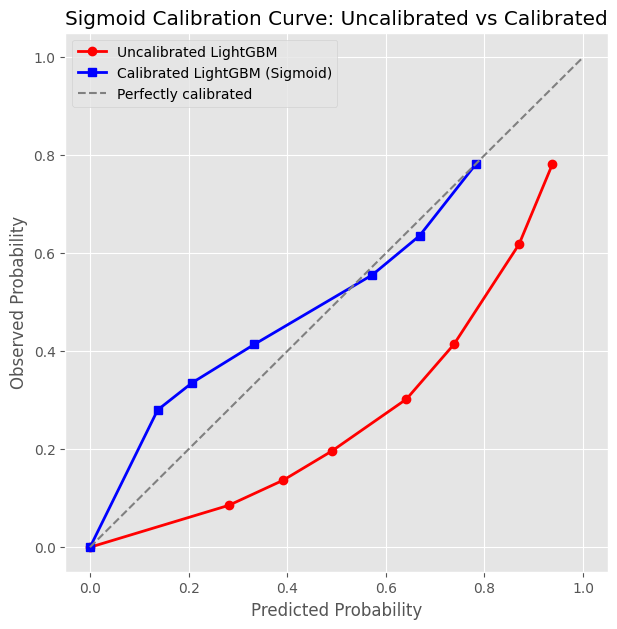

In [18]:
#---Sigmoid Calibration Curve

y_prob_uncal = lgb_best.predict_proba(X_test)[:, 1]
y_prob_cal   = lgb_test_probs_calibrated

y_true = Y_test

prob_true_uncal, prob_pred_uncal = calibration_curve(y_true, y_prob_uncal, n_bins=10, strategy='uniform')
prob_true_cal,   prob_pred_cal   = calibration_curve(y_true, y_prob_cal, n_bins=10, strategy='uniform')

plt.figure(figsize=(7, 7))
plt.plot(prob_pred_uncal, prob_true_uncal, marker='o', linewidth=2, label='Uncalibrated LightGBM', color='red')
plt.plot(prob_pred_cal, prob_true_cal, marker='s', linewidth=2, label='Calibrated LightGBM (Sigmoid)', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

plt.title('Sigmoid Calibration Curve: Uncalibrated vs Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\edjwe\pyenv\Lib\site-packages\sklearn\metrics\_classifi

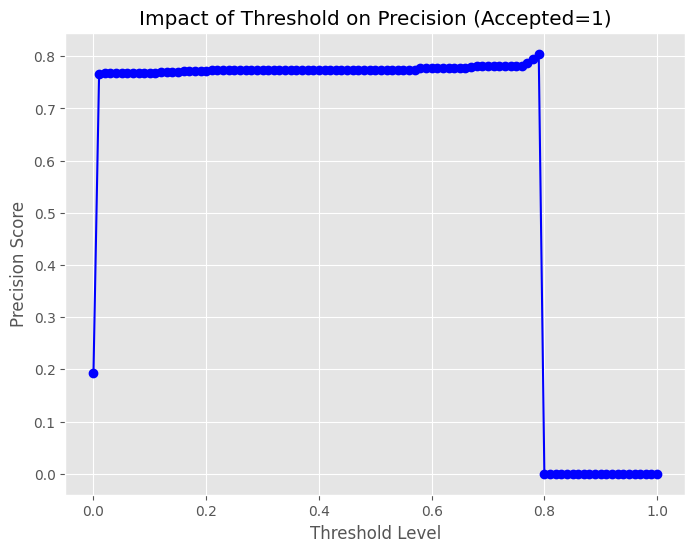

In [19]:
#---Threshold vs Precision Plot

#Probabilities for positive class
y_prob = lgb_test_probs_calibrated
y_true = Y_test

#Thresholds
thresholds = np.linspace(0, 1, 101)
precision_scores = []

#Precision by threshold
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    precision_scores.append(precision_score(y_true, y_pred, pos_label=1))

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, marker='o', linestyle='-', color='blue')
plt.title('Impact of Threshold on Precision (Accepted=1)')
plt.xlabel('Threshold Level')
plt.ylabel('Precision Score')
plt.grid(True)
plt.show()

In [20]:
#---Fully Interactive PLot of Various Metrics across different Thresholds

#Precompute metrics across thresholds
thresholds = np.linspace(0, 1, 101)
precision_vals, recall_vals, f1_vals = [], [], []
type1_vals, type2_vals = [], []

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    precision_vals.append(precision_score(y_true, preds, pos_label=1, zero_division=0))
    recall_vals.append(recall_score(y_true, preds, pos_label=1))
    f1_vals.append(f1_score(y_true, preds, pos_label=1))
    
    cm = confusion_matrix(y_true, preds, labels=[0,1])
    TN, FP, FN, TP = cm.ravel()
    type1_vals.append(FP / (FP + TN) if (FP + TN) > 0 else 0)
    type2_vals.append(FN / (FN + TP) if (FN + TP) > 0 else 0)

#Interactive function
def threshold_analysis_with_errors(threshold=0.5):
    preds = (y_prob >= threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_true, preds, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    # Metrics
    precision = precision_score(y_true, preds, pos_label=1, zero_division=0)
    recall    = recall_score(y_true, preds, pos_label=1)
    f1        = f1_score(y_true, preds, pos_label=1)

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    kappa = cohen_kappa_score(y_true, preds)

    type1_error = FP / (FP + TN) if (FP + TN) > 0 else 0
    type2_error = FN / (FN + TP) if (FN + TP) > 0 else 0

    #Plot metrics and errors
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, precision_vals, label='Precision', color='blue')
    plt.plot(thresholds, recall_vals, label='Recall', color='green')
    plt.plot(thresholds, f1_vals, label='F1 Score', color='orange')
    plt.plot(thresholds, type1_vals, label='Type I Error (FP Rate)', color='red', linestyle='--')
    plt.plot(thresholds, type2_vals, label='Type II Error (FN Rate)', color='purple', linestyle='--')
    plt.axvline(threshold, color='black', linestyle=':', label=f'Selected Threshold={threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score / Error Rate')
    plt.title('Precision, Recall, F1 and Type I/II Errors by Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    #Confusion matrix heatmap
    annot_labels = np.array([
        [f'{cm_norm[0,0]:.4f}\n(TN={TN:,})', f'{cm_norm[0,1]:.4f}\n(FP={FP:,})'],
        [f'{cm_norm[1,0]:.4f}\n(FN={FN:,})', f'{cm_norm[1,1]:.4f}\n(TP={TP:,})']
    ])
    
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        cm_norm,
        annot=annot_labels,
        fmt='',
        cmap='Blues',
        xticklabels=['Pred 0 (Rejected)', 'Pred 1 (Accepted)'],
        yticklabels=['Actual 0 (Rejected)', 'Actual 1 (Accepted)'],
        cbar=True
    )

    #Type I Error Label
    ax.text(
        1 + .5, 0 + .3,
        'Type I Error',
        ha='center', va='bottom',
        color='red',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
    )
    
    #Type II Error Label
    ax.text(
        0 + 0.5, 1 + 0.3,
        'Type II Error',
        ha='center', va='bottom',
        color='red',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2')
)
    plt.title(f'Normalized Confusion Matrix (Threshold={threshold:.2f})')
    plt.show()

    print(f'TN= {TN:,}  FP= {FP:,}')
    print(f'FN= {FN:,}  TP= {TP:,}\n')
    print(f'Accuracy:    {accuracy:.4f}')
    print(f'Precision:   {precision:.4f}')
    print(f'Recall:      {recall:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'F1 Score:    {f1:.4f}')
    print(f'Kappa:       {kappa:.4f}')
    print(f'Type I Error (FP Rate):  {type1_error:.4f}')
    print(f'Type II Error (FN Rate): {type2_error:.4f}')

#Interactive slider
widgets.interact(threshold_analysis_with_errors, threshold=widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='Threshold'));

interactive(children=(FloatSlider(value=0.5, description='Threshold', max=1.0, step=0.01), Output()), _dom_cla…